<a href="https://colab.research.google.com/github/vickyrana123/Stock-Market-Prediction-Bot/blob/main/Stock_Market_Prediction_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import pandas as pd
import numpy as np
import math
from datetime import date,timedelta
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mplt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf
import matplotlib.dates as mdates



In [143]:
today=date.today()
date_today=today.strftime("%Y-%m-%d")
date_start="2022-10-01"


**Get Stock**

In [144]:
stock=input("Enter Stock Name:")
stockname=stock
symbol = '^GSPC'
df = yf.download(symbol, start=date_start, end=date_today)

Enter Stock Name:Tata Motor
[*********************100%%**********************]  1 of 1 completed


In [145]:
print(df.shape)


(257, 6)


In [146]:

df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-03,3609.780029,3698.350098,3604.929932,3678.429932,3678.429932,4806680000
2022-10-04,3726.459961,3791.919922,3726.459961,3790.929932,3790.929932,5146580000
2022-10-05,3753.250000,3806.909912,3722.659912,3783.280029,3783.280029,4293180000
2022-10-06,3771.969971,3797.929932,3739.219971,3744.520020,3744.520020,4252100000
2022-10-07,3706.739990,3706.739990,3620.729980,3639.659912,3639.659912,4449660000


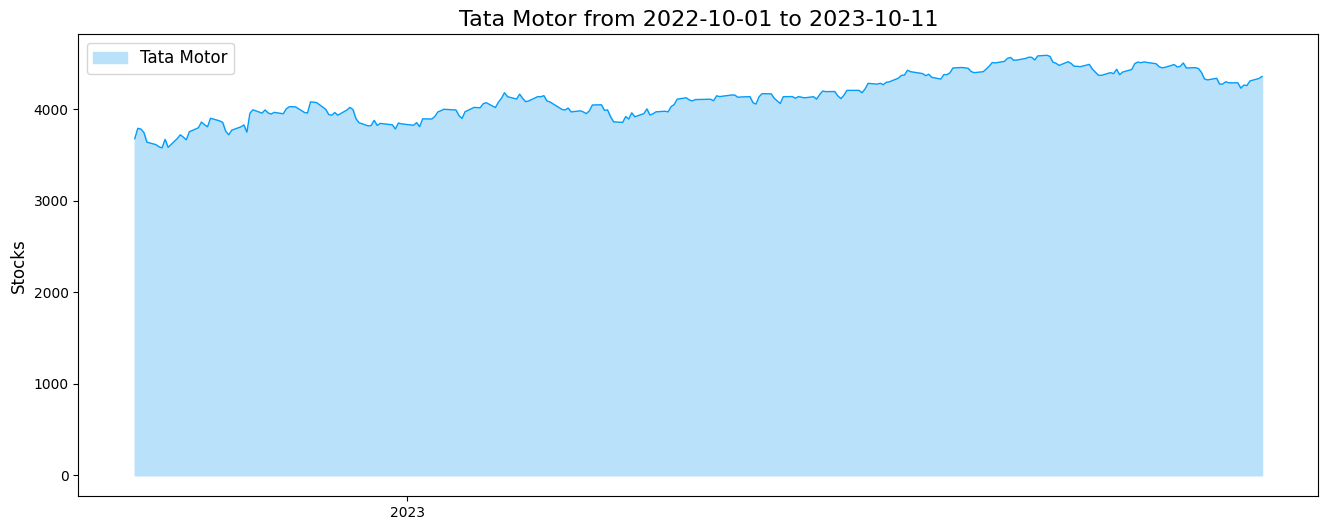

In [147]:
register_matplotlib_converters()
years = mdates.YearLocator()
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('Stocks', fontsize=12)
plt.show()

In [148]:
train_df = df.filter(['Close'])
data_unscaled = train_df.values

**Train the model on 80% of the data**

In [149]:
train_data_length = math.ceil(len(data_unscaled) * 0.8)

In [150]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

sequence_length = 50

In [151]:
index_Close = train_df.columns.get_loc("Close")
print(index_Close)

0


In [152]:
train_data_len = math.ceil(np_data.shape[0] * 0.8)

In [153]:
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [154]:
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i - sequence_length:i, :])  # contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[
                     i, index_Close])
    x = np.array(x)
    y = np.array(y)
    return x, y

In [155]:
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(156, 50, 1) (156,)
(51, 50, 1) (51,)


In [156]:
print(x_test[1][sequence_length - 1][index_Close])
print(y_test[0])

1.0000000000000004
1.0000000000000004


In [157]:
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [158]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=16, epochs=8)


y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/8
10/10 [==============================] - 3s 25ms/step - loss: 0.2000
Epoch 2/8
10/10 [==============================] - 0s 22ms/step - loss: 0.0317
Epoch 3/8
10/10 [==============================] - 0s 27ms/step - loss: 0.0226
Epoch 4/8
10/10 [==============================] - 0s 25ms/step - loss: 0.0151
Epoch 5/8
10/10 [==============================] - 0s 25ms/step - loss: 0.0132
Epoch 6/8
10/10 [==============================] - 0s 26ms/step - loss: 0.0104
Epoch 7/8
10/10 [==============================] - 0s 26ms/step - loss: 0.0083
Epoch 8/8
10/10 [==============================] - 0s 24ms/step - loss: 0.0070


2/2 [==============================] - 1s 10ms/step


In [159]:
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

Median Absolute Error (MAE): 87.67


In [160]:
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 2.01 %


In [161]:
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Percentage Error (MDAPE): 1.61 %


In [162]:
display_start_date = "2022-01-01"

In [163]:
train = train_df[:train_data_length + 1]
valid = train_df[train_data_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

In [164]:
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

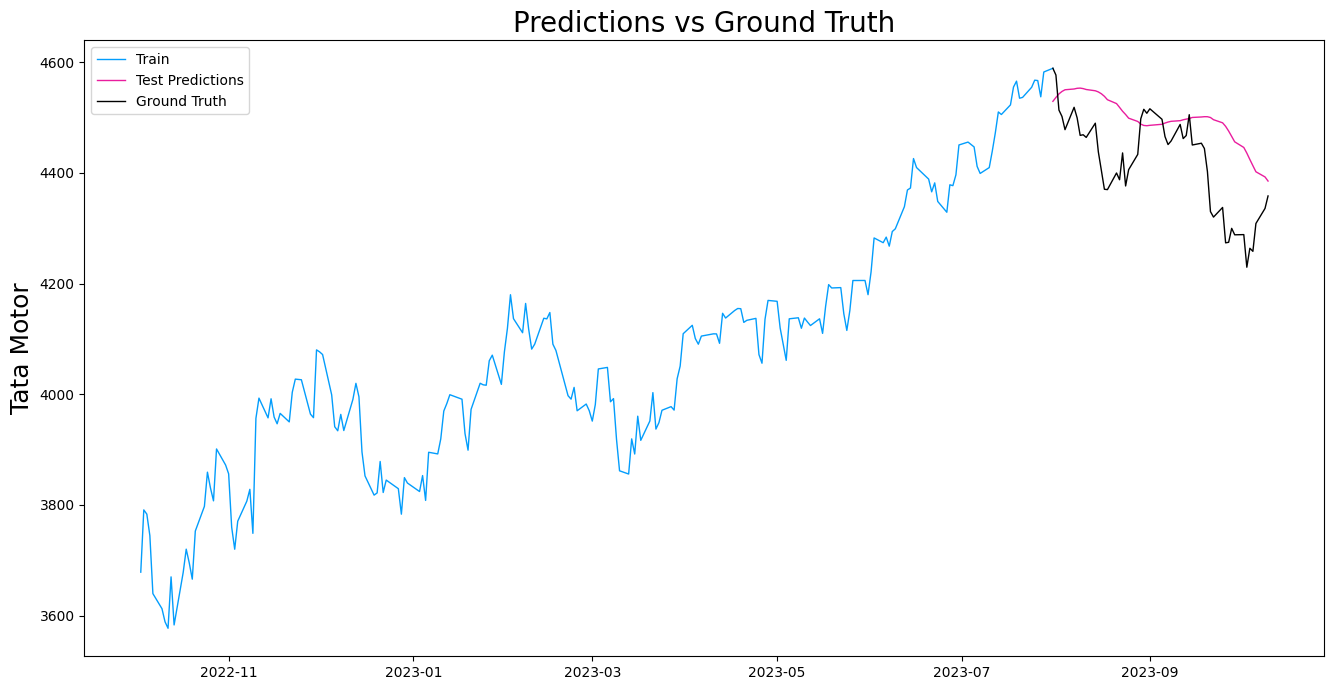

In [165]:
fig, ax = plt.subplots(figsize=(16, 8), sharex=True)

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(train["Close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

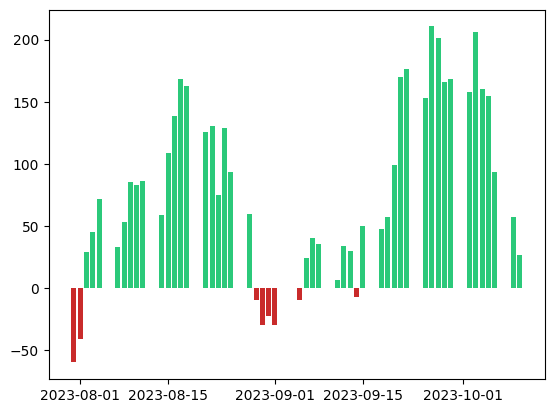

In [166]:
valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

In [167]:
dif = valid['Close'] - valid['Predictions']
valid.insert(2, 'Difference', dif, True)
valid.tail(5)

,Close,Difference,Difference,Predictions,diff_color
Date,,,,,
2023-10-04,4263.750000,160.365234,-160.365234,4424.115234,#2BC97A
2023-10-05,4258.189941,154.762207,-154.762207,4412.952148,#2BC97A
2023-10-06,4308.500000,93.434570,-93.434570,4401.934570,#2BC97A
2023-10-09,4335.660156,56.944336,-56.944336,4392.604492,#2BC97A
2023-10-10,4358.240234,26.947266,-26.947266,4385.187500,#2BC97A


In [168]:
df_new = df.filter(['Close'])
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

In [169]:
X_test = []
X_test.append(last_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [170]:
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)
price_today = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')


1/1 [==============================] - 0s 18ms/step
The close price for Tata Motor at 2023-10-11 was 4358.24
The predicted close price is 4379.8701171875 (-0.5%)
